In [1]:
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import csv
from datetime import date
import time

import seaborn as sns
import matplotlib.pyplot as plt

# for custom functions
import os
import sys
# import sys; sys.path.insert(0, '..')
# from lib.custom_functions import * 

import warnings
warnings.filterwarnings('ignore')

#### Custom Functions
Custom functions for data processing and preparation.

In [2]:

def mean(s: pd.Series):
    return round(s.mean(), 2)

def median(s: pd.Series):
    return s.median()

def drop_features(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    print('drop_features')
    df = df.drop(columns, axis=1)
    return df

def remove_free_listings(df: pd.DataFrame, price_column: str) -> pd.DataFrame:
    print('remove free listings.')
    try:
        df = df.loc[df[price_column] > 0.0, :]
    except Exception as e:
        pass
    return df


def bool_to_binary(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    print('bool_to_binary')
    for column in columns:
        local_kwargs = {column : lambda df: df[column].astype(str).str.replace('t', '1').replace('f', '0').replace('True', '1').replace('False', '0').astype(int)}

        df = (
            df
            .assign(**local_kwargs)
        )
        
        return df
    
def process_neighbourhoods(df: pd.DataFrame, quantile: float=0.75) -> pd.DataFrame:
    print('process_neighbourhoods')
    if os.path.isfile('data/features/neighbourhoods_to_keep.csv'):
        print('process_neighbourhoods -> reading neighbourhoods_to_keep from file')
        neighbourhoods_to_keep = pd.read_csv('data/features/neighbourhoods_to_keep.csv')
        
    else:
        print('process_neighbourhoods -> processing neighbourhoods_to_keep')
        yf = df.groupby(by=['neighbourhood']).id.count().sort_values(ascending=False).reset_index()
        neighbourhoods_to_keep = (
            pd.DataFrame(yf.loc[yf.id > yf.id.quantile(q=quantile), 'neighbourhood'])
            .assign(neighbourhood_to_keep=lambda df: df['neighbourhood'])
            .drop('neighbourhood', axis=1)
        )
        neighbourhoods_to_keep.to_csv('data/features/neighbourhoods_to_keep.csv')
        
    df = (
        df
        .merge(neighbourhoods_to_keep, how='left', left_on='neighbourhood', right_on='neighbourhood_to_keep')
    )
    
    return df
        
def fill_na(df: pd.DataFrame, replacements: dict) -> pd.DataFrame:
    print('fill_na')
    for k, v in replacements.items():

        if callable(v):
            if os.path.isfile(f'data/features/{k}_replacement'):
                print(f'fill_na -> reading {k}_replacement from file')
                with open(f'data/features/{k}_replacement', 'r') as f:
                    value = f.read()
                    f.close()

            else:
                value = v(df[k])
                with open(f'data/features/{k}_replacement', 'w') as f: 
                    print(f'fill_na -> writing {k}_replacement to file')
                    f.write(str(value))
                
        else:
            value = v
        
        local_kwargs = {k : lambda df: df[k].fillna(value)}

        df = (
            df
            .assign(**local_kwargs)
        )
    return df

def one_hot_encoder(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    print('one_hot_encoder')
    df = pd.get_dummies(
        df, columns=columns, prefix='', prefix_sep=''
    )

    return df

def process_host_response_rate(df: pd.DataFrame) -> pd.DataFrame:
    df = (
        df
        .assign(host_response_rate=lambda df: df.host_response_rate.str.replace('%', '').astype(float))
        .assign(host_response_class=lambda df: pd.cut(df.host_response_rate, 
                                                    bins=[0, 75, 80, 85, 90, 95, 100.00], 
                                                    labels=['very_low',
                                                            'low',
                                                            'medium',
                                                            'high',
                                                            'very_high',
                                                            'best'], 
                                                    include_lowest=True))
        .assign(host_response_class=lambda df: df.host_response_class.cat.add_categories('other').fillna('other'))
        .drop('host_response_rate', axis=1)
    )
    
    return df

def process_review_dates(df: pd.DataFrame) -> pd.DataFrame:
    print('process_review_dates')
    df = (
    df
        .assign(first_review=lambda df: pd.to_datetime(df.first_review))
        .assign(last_review=lambda df: pd.to_datetime(df.last_review))
        .assign(host_since=lambda df: pd.to_datetime(df.host_since))
        .assign(today=[date.today()]*len(df.index))
        .assign(today=lambda df: pd.to_datetime(df.today))
        .assign(days_since_first_review=lambda df: (df.today - df.first_review).dt.days)
        .assign(days_since_last_review=lambda df: (df.today - df.last_review).dt.days)
        .assign(days_host_since=lambda df: (df.today - df.host_since).dt.days)
        .assign(first_review_class=lambda df: pd.cut(df.days_since_first_review, 
                                                    bins=[0, 1095, 1280, 1460, 1645, 1830, max(df.days_since_first_review)], 
                                                    labels=['0y-3y',
                                                            '3y-3y6m',
                                                            '3y6m-4y',
                                                            '4y-4y6m',
                                                            '4y6m-5y',
                                                            '5y'], 
                                                    include_lowest=True))
        .assign(last_review_class=lambda df: pd.cut(df.days_since_last_review, 
                                                    bins=[0, 1095, 1220, 1460, 1645, 1830, max(df.days_since_first_review)], 
                                                    labels=['0y-3y',
                                                            '3y-3y6m',
                                                            '3y6m-4y',
                                                            '4y-4y6m',
                                                            '4y6m-5y',
                                                            '5y'], 
                                                    include_lowest=True))
        .assign(first_review_class=lambda df: df.first_review_class.cat.add_categories('other').fillna('other'))
        .assign(last_review_class=lambda df: df.last_review_class.cat.add_categories('other').fillna('other'))
        .assign(days_host_since=lambda df: df.days_host_since.fillna(1))
        .drop(['first_review', 'last_review', 'today', 'days_since_first_review', 'days_since_last_review', 'host_since'], axis=1)
    )
    
    return df

def process_amenities(df: pd.DataFrame) -> pd.DataFrame:
    print('process_amenities')
    amenities_to_keep = []
    
    if os.path.isfile('data/features/amenities_to_keep'):
        print('process_amenities -> reading amenities_to_keep from file')
        with open('data/features/amenities_to_keep', 'r') as f: 
            reader = csv.reader(f)

            for row in reader:
                amenities_to_keep = row
            
    if not amenities_to_keep:
        print('process_amenities -> processing amenities_to_keep')
        amenities = [x.strip() for x in ", ".join(list(df.amenities)).replace('{', '').replace('}', '').replace('"', '').replace('TV', '').split(',')]

        amenities_counter = {}
        for amenity in amenities:
            if amenity in amenities_counter.keys():
                amenities_counter[amenity] += 1
            else:
                amenities_counter[amenity] = 1

        amenities_counter_sorted = {k: v for k, v in sorted(amenities_counter.items(), key=lambda item: item[1])}

        amenities_to_keep = []
        records_count = (len(amenities_counter_sorted) + 0.001)
        for i, e in (enumerate(amenities_counter_sorted.items())):
            if (i*100.0/records_count > 20 or i*100.0/records_count < 80) \
            and (e[1] > 2) \
            and ("translation missing" not in e[0]) \
            and (e[0] != ''):
                amenities_to_keep.append(e[0])
                
        with open('data/features/amenities_to_keep', 'w') as f: 
            print('process_amenities -> writing amenities_to_keep to file')
            write = csv.writer(f) 
            write.writerow(amenities_to_keep)
                
        
    print('process_amenities -> applying amenities_to_keep to dataframe')
    start = time.time()
    for amenity in amenities_to_keep:
        df[amenity] = df.apply(lambda row: 1 if amenity in row.amenities else 0, axis=1)
        
    print(f'process_amenities -> finished applying amenities_to_keep to dataframe in {time.time() - start} seconds.')       
        
    df = df.drop(['amenities'], axis=1)
    
    return df

def process_property_type(df: pd.DataFrame, column: str, replacements: dict) -> pd.DataFrame:
    print('process_property_type')
    local_kwargs = {column : lambda df: df[column].replace(replacements)}

    df = (
        df
        .assign(**local_kwargs)
    )
    
    df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'other'

    return df

### Data preparation
Cleaned data preparation pipeline for easier handling and maintenance.

We save the training attributes, such as which amenities and neighborhoods to keep from the training set in order to use the same ones on the new unseen test set.

A file with the training data processed is saved for just running the pipeline once.

In [3]:
def data_process_pipeline(df: pd.DataFrame, data_path: str) -> pd.DataFrame:
    
    df_processed = (
    df
    .pipe(drop_features, columns=['latitude', 'longitude', 'name', 'thumbnail_url', 'zipcode', 'host_has_profile_pic', 'description'])
    .pipe(remove_free_listings, price_column='log_price')
    .pipe(fill_na, replacements={'neighbourhood': 'other'})
    .pipe(process_neighbourhoods, quantile=0.8)
    .pipe(drop_features, columns=['neighbourhood'])
    .pipe(fill_na, replacements={'number_of_reviews': 0,
                                 'bedrooms': 0,
                                 'review_scores_rating': mean,
                                 'beds': median,
                                 'bathrooms': median,
                                 'accommodates': median,
                                 'neighbourhood_to_keep': 'other'})
    .pipe(bool_to_binary, columns=['cleaning_fee', 'host_identity_verified', 'instant_bookable'])
    .pipe(process_property_type, column='property_type', replacements={'Townhouse': 'House',
                                                                       'Bungalow': 'House',
                                                                       'Cottage': 'House',
                                                                       'Villa': 'House',
                                                                       'Tiny house': 'House',
                                                                       'Chalet': 'House',
                                                                       'Serviced apartment': 'Apartment',
                                                                       'Loft': 'Apartment',
                                                                       'Condominium': 'Apartment'})
    .pipe(process_host_response_rate)
    .pipe(process_review_dates)
    .pipe(process_amenities)
    .pipe(one_hot_encoder, 
          columns=['instant_bookable', 
                   'host_identity_verified', 
                   'city', 
                   'cleaning_fee',
                   'cancellation_policy', 
                   'bed_type', 
                   'room_type', 
                   'host_response_class', 
                   'neighbourhood_to_keep', 
                   'property_type',
                   'first_review_class',
                   'last_review_class'])

    )
        
    columns_to_drop = [col for col in df_processed.columns if 'Unnamed' in col]
    df_processed = df_processed.drop(columns_to_drop, axis=1)
    
    df_processed.to_csv(data_path)
    
    return df_processed

In [4]:
if os.path.isfile('data/train_processed.csv'):
    df_train_processed = pd.read_csv('data/train_processed.csv')
    
else:
    df_train = pd.read_csv('data/train.csv')
    df_train_processed = data_process_pipeline(df_train, 'data/train_processed.csv')

print(f'Number of features: {len(df_train_processed.columns) - 1}')
print(f'Number of rows: {len(df_train_processed.index)}')
df_train_processed.head()

Number of features: 301
Number of rows: 74110


,Unnamed: 0,id,log_price,accommodates,bathrooms,number_of_reviews,review_scores_rating,bedrooms,beds,days_host_since,...,4y6m-5y,5y,other.3,0y-3y.1,3y-3y6m.1,3y6m-4y.1,4y-4y6m.1,4y6m-5y.1,5y.1,other.4
0,0,6901257,5.010635,3,1.0,2,100.00,1.0,1.0,3188.0,...,0,0,0,0,0,0,1,0,0,0
1,1,6304928,5.129899,7,1.0,6,93.00,3.0,3.0,1277.0,...,0,0,0,0,1,0,0,0,0,0
2,2,7919400,4.976734,5,1.0,10,92.00,1.0,3.0,1514.0,...,0,0,0,0,1,0,0,0,0,0
3,3,13418779,6.620073,4,1.0,0,94.07,2.0,2.0,2069.0,...,0,0,1,0,0,0,0,0,0,1
4,4,3808709,4.744932,2,1.0,4,40.00,0.0,1.0,2118.0,...,0,1,0,0,0,1,0,0,0,0


# Models

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, ElasticNetCV, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [6]:
def get_model_scores(y_test, pred):
    return (np.sqrt(mean_squared_error(y_test[[regressand]], pred))), r2_score(y_test[[regressand]], pred)

def get_model_yf(y_test, pred, model, regressand='log_price'):
    mod_pred_df = (
    pd.DataFrame(pred, columns=[regressand])
    )
    mod_pred_df['class'] = 'predicted'
    
    mod_yf = pd.concat([mod_pred_df, y_test])
    mod_yf['model'] = model
    
    return mod_yf

model_scores = {}
    

## Train, Test and Holded Data
We split the training set intro *train* and *test*, and we *hold* the provided test set to simulate 100% unseen data. Given that there are some parameters that were tuned with trained data and these same parameters should be used in production environment when predicting unseen data.

the test.csv file has the holded data.

#### Holded Data

In [7]:
if os.path.isfile('data/test_processed.csv'):
    df_test_processed = pd.read_csv('data/test_processed.csv')
    
else:
    df_test = pd.read_csv('data/test.csv')
    df_test_processed = data_process_pipeline(df_test, 'data/test_processed.csv')

print(f'Number of features: {len(df_test_processed.columns) - 1}')
print(f'Number of rows: {len(df_test_processed.index)}')

df_test_processed.head()

Number of features: 301
Number of rows: 25458


,Unnamed: 0,id,accommodates,bathrooms,number_of_reviews,review_scores_rating,bedrooms,beds,days_host_since,Roll-in shower with chair,...,4y6m-5y,5y,other.3,0y-3y.1,3y-3y6m.1,3y6m-4y.1,4y-4y6m.1,4y6m-5y.1,5y.1,other.4
0,0,3895911,2,1.0,6,97.00,1.0,1.0,1587.0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,9710289,3,1.0,2,80.00,1.0,1.0,2570.0,0,...,0,0,0,0,0,0,1,0,0,0
2,2,9051635,1,1.0,2,100.00,1.0,1.0,3425.0,0,...,0,0,0,0,0,0,1,0,0,0
3,3,708374,1,1.0,7,94.00,0.0,1.0,3095.0,0,...,0,1,0,0,0,1,0,0,0,0
4,4,626296,2,1.0,0,94.07,1.0,1.0,1801.0,0,...,0,0,1,0,0,0,0,0,0,1


In [8]:
regressand = 'log_price'
X = df_train_processed.loc[:, df_train_processed.columns != regressand]
y = df_train_processed.loc[:, df_train_processed.columns == regressand]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=9)

y_test['class'] = 'y_test'

yf = pd.DataFrame() # for saving model predictions

### Linear Regression

In [9]:
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, y_train)

pred = lin_reg_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
lin_reg_mod_yf = get_model_yf(y_test, pred, model='linear_regression')

model_scores['lin_reg_mod'] = {
    'model': lin_reg_mod,
    'rmse': test_set_rmse,
    'r2': test_set_r2
}
# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.4196550820932791
Test R2: 0.650469957027094


### ElasticNet Regression

In [10]:
en_mod = ElasticNet(alpha=0.2)
en_mod.fit(X_train, y_train)

pred = en_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
en_mod_yf = get_model_yf(y_test, pred, model='en_regression')

model_scores['en_mod'] = {
    'model': en_mod,
    'rmse': test_set_rmse,
    'r2': test_set_r2
}
# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.563248665271858
Test R2: 0.370349026502373


### ElasticNet Regression CV
Elastic net with cross validation for choosing best alpha parameter

In [11]:
en_cv_mod = ElasticNetCV(l1_ratio=0.2, n_alphas=100, cv=10)
en_cv_mod.fit(X_train, y_train)

pred = en_cv_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
en_cv_mod_yf = get_model_yf(y_test, pred, model='en_cv_regression')

model_scores['en_cv_mod'] = {
    'model': en_cv_mod,
    'rmse': test_set_rmse,
    'r2': test_set_r2
}
# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.7081353684255965
Test R2: 0.004750177211147899


### Ridge Regression

In [12]:
ridge_mod = Ridge()
ridge_mod.fit(X_train, y_train)

pred = ridge_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
ridge_mod_yf = get_model_yf(y_test, pred, model='ridge_regression')

model_scores['ridge_mod'] = {
    'model': ridge_mod,
    'rmse': test_set_rmse,
    'r2': test_set_r2
}
# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.4196400961674324
Test R2: 0.6504949200884429


### Multilayer NN Regression

In [13]:
from sklearn.preprocessing import StandardScaler


multi_nn_mod = MLPRegressor(solver='sgd')

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

multi_nn_mod.fit(X_train, y_train)

pred = multi_nn_mod.predict(X_test)

#Model Scores
test_set_rmse, test_set_r2 = get_model_scores(y_test[[regressand]], pred)

# for plotting distributions
multi_nn_mod_yf = get_model_yf(y_test, pred, model='multi_nn_regression')

model_scores['multi_nn_mod'] = {
    'model': multi_nn_mod,
    'rmse': test_set_rmse,
    'r2': test_set_r2
}
# model results
print(f'Test RMSE: {test_set_rmse}')
print(f'Test R2: {test_set_r2}')

Test RMSE: 0.4202046467543217
Test R2: 0.6495538945542352


### Plot, actual vs predicted price

In [14]:
yf = (
    pd.concat([lin_reg_mod_yf, en_mod_yf, en_cv_mod_yf, ridge_mod_yf, multi_nn_mod_yf])
)

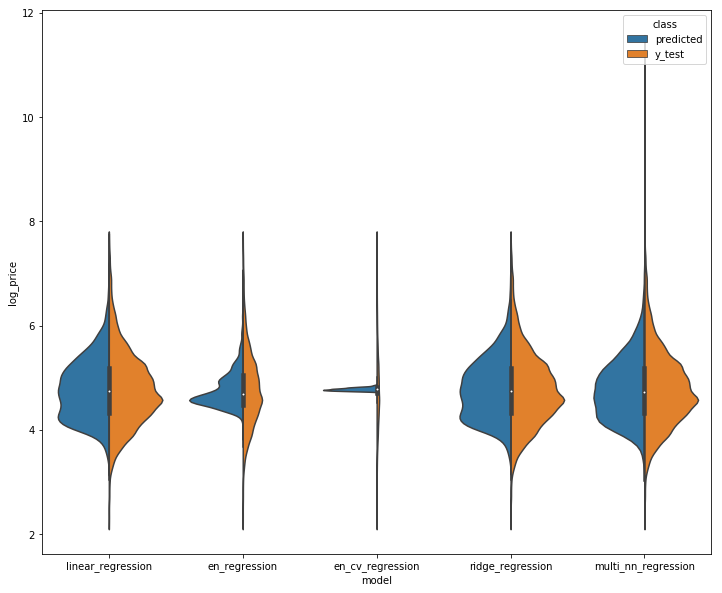

In [15]:
fig, ax = plt.subplots(figsize=(12,10))
sns.violinplot(x='model',
               y='log_price',
               hue='class',
               data=yf,
               split=True,
               ax=ax)

plt.savefig('figures/eta_pre_violin.png')
plt.show()

## Picking Model
Choose model that minimizes RMSE

In [16]:
min_RMSE = 1
max_R2 = 0
for model, props in model_scores.items():
    if (props['rmse'] <= min_RMSE):
        if (props['r2'] >= max_R2):
            min_RMSE = props['rmse']
            max_R2 = props['r2']
            best_model = model
        
        
        
print(f'best model: {model}')

best model: multi_nn_mod
